In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from os import chdir 
chdir('C:\\Users\\afeki\\Desktop\\Code\\BootStrapDesicionTree\\')

In [2]:
from gradient_boosting_trees.gradient_boosting_regressor import CartGradientBoostingRegressor, \
    CartGradientBoostingRegressorKfold
from gradient_boosting_trees.gradient_boosting_abstract import GradientBoostingMachine
from Tree.node import Leaf


from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

from sklearn.model_selection import train_test_split

import xgboost as xgb

from catboost import Pool, CatBoostRegressor

# Config

In [3]:
A1 = 2
A2 = 5
SIGMNA = 3
N_ROWS = 10**3
VAL_RATIO = 0.15
CATEGORICAL_DISTRIBUTION = 'uniform'
CATEGORY_SIZE = 100
CATEGORY_COLUMN_NAME = 'category'
Y_COL_NAME = 'y'
LEFT_GROUP = [i for i in range(CATEGORY_SIZE//2)]
SEED = 5
np.random.seed(SEED)
CATEGORIES = np.arange(10, 200, 10)
N_EXPERIMENTS = 2

In [4]:
MAX_DEPTH = 4
N_ESTIMATORS = 100
LEARNING_RATE = 0.1

In [5]:
mse_val = {}
results_df = pd.DataFrame(index = CATEGORIES)

# Create simulated data
$$ y = a_1 \cdot x_1 + a_2 \cdot I(x_2 \in LEFT\_GROUP) + \sigma $$

$$ x1 - N(0,1) $$

In [6]:
def create_x_y(category_size):
    X = pd.DataFrame()
    X[CATEGORY_COLUMN_NAME] = np.random.randint(0, category_size, N_ROWS)
    X['x1'] = np.random.randn(N_ROWS)
    X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('category')
    sigma = SIGMNA*np.random.randn(N_ROWS)
    left_group = [i for i in range(category_size//2)]
    y = A1*X['x1'] + A2*X[CATEGORY_COLUMN_NAME].isin(left_group) + sigma
    return X,y

def create_x(category_size):
    X = pd.DataFrame()
    X[CATEGORY_COLUMN_NAME] = np.random.randint(0, category_size, N_ROWS)
    X['x1'] = np.random.randn(N_ROWS)
    X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('category')
    sigma = SIGMNA*np.random.randn(N_ROWS)
    left_group = [i for i in range(category_size//2)]
    X[Y_COL_NAME] = A1*X['x1'] + A2*X[CATEGORY_COLUMN_NAME].isin(left_group) + sigma
    return X

In [7]:
from xgboost.core import Booster
def compute_ntrees_nleaves(gbm):
    total_number_of_trees = 0
    total_number_of_leaves = 0
    if isinstance(gbm,GradientBoostingMachine):
        for tree in gbm.trees:
            if not isinstance(tree.root, Leaf):
                total_number_of_trees += 1
                total_number_of_leaves += tree.n_leaves
    elif isinstance(gbm,GradientBoostingClassifier) or isinstance(gbm,GradientBoostingRegressor):
        total_number_of_trees = gbm.n_estimators_
        for tree in gbm.estimators_:
            total_number_of_leaves += tree[0].get_n_leaves()
    elif isinstance(gbm, Booster):
        df = gbm.trees_to_dataframe()
        total_number_of_leaves = df[df['Feature'] == 'Leaf'].shape[0]
        total_number_of_trees = df[df['Feature'] == 'Leaf']['Tree'].max()

    print(F'number of trees is {total_number_of_trees}')
    print(F'number of leaves is {total_number_of_leaves}')

In [8]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin


# Pandas one hot encoder
class OneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.unique_values_for_col = {}

    def fit(self, X, y=None):
        for col in X.columns:
            self.unique_values_for_col[col] = X[col].unique().tolist()

    def transform(self, X):
        dataframes = []
        for col in X.columns:
            type = CategoricalDtype(categories=self.unique_values_for_col[col])
            dataframes.append(pd.get_dummies(pd.Series(X[col], dtype=type), prefix=col))
        return pd.concat(dataframes, axis=1)

# OUR IMPLEMENTATION
## KFOLD

In [9]:
exp_name = 'Ours_Kfold'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X = create_x(category_size)
        X, X_val = train_test_split(X, test_size=VAL_RATIO, random_state=42)
        y_val = X_val[Y_COL_NAME]
        X_val =  X_val.drop(columns = [Y_COL_NAME])
        reg = CartGradientBoostingRegressorKfold(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
        reg.fit(X)
        fi = pd.Series(reg.compute_feature_importance()).sort_index()
        fi/= fi.sum()
        temp_results.append(np.mean(np.square(y_val -reg.predict(X_val))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

100%|██████████| 19/19 [13:04<00:00, 41.29s/it]


In [10]:
# from Tree.tree_visualizer import TreeVisualizer
# tree_vis = TreeVisualizer()
# tree_vis.plot(kfold_gbm.trees[0].root)

# compute_ntrees_nleaves(kfold_gbm)

## Vanilla gradient boosting regressor

In [11]:
exp_name = 'Ours_Vanilla'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X = create_x(category_size)
        X, X_val = train_test_split(X, test_size=VAL_RATIO, random_state=42)
        y_val = X_val[Y_COL_NAME]
        X_val =  X_val.drop(columns = [Y_COL_NAME])
        vanilla_gbm = CartGradientBoostingRegressor(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
        reg.fit(X)
        fi = pd.Series(reg.compute_feature_importance()).sort_index()
        fi/= fi.sum()
        temp_results.append(np.mean(np.square(y_val -reg.predict(X_val))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

100%|██████████| 19/19 [13:38<00:00, 43.07s/it]


In [12]:
# compute_ntrees_nleaves(vanilla_gbm)
# tree_vis = TreeVisualizer()
# tree_vis.plot(vanilla_gbm.trees[0].root)

## Ours Mean Imputing

In [13]:
def create_mean_imputing_x_x_val(x, y,x_val):
    temp_x = x.copy()
    temp_x[Y_COL_NAME] = y
    category_to_mean = temp_x.groupby(CATEGORY_COLUMN_NAME)[Y_COL_NAME].mean().to_dict()
    temp_x[CATEGORY_COLUMN_NAME] = temp_x[CATEGORY_COLUMN_NAME].map(category_to_mean)
    temp_x = temp_x.drop(columns = [Y_COL_NAME])
    temp_x[CATEGORY_COLUMN_NAME] = temp_x[CATEGORY_COLUMN_NAME].astype('float')
    x_val[CATEGORY_COLUMN_NAME] = x_val[CATEGORY_COLUMN_NAME].map(category_to_mean)
    x_val[CATEGORY_COLUMN_NAME] = x_val[CATEGORY_COLUMN_NAME].astype('float')
    x_val[CATEGORY_COLUMN_NAME] = x_val[CATEGORY_COLUMN_NAME].fillna(x_val[CATEGORY_COLUMN_NAME].mean())
    return temp_x , x_val

exp_name = 'Ours_MeanImputing'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_mean_imputing_x_x_val(X, y,X_val)
        X[Y_COL_NAME] = y
        reg = CartGradientBoostingRegressor(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
        reg.fit(X)
        fi = pd.Series(reg.compute_feature_importance()).sort_index()
        fi/= fi.sum()
        temp_results.append(np.mean(np.square(y_val -reg.predict(X_val))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

100%|██████████| 19/19 [05:50<00:00, 18.47s/it]


## Ours mean imputing with kfold

In [14]:
exp_name = 'Ours_MeanImputingKfold'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_mean_imputing_x_x_val(X, y,X_val)
        X[Y_COL_NAME] = y
        reg = CartGradientBoostingRegressorKfold(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
        reg.fit(X)
        fi = pd.Series(reg.compute_feature_importance()).sort_index()
        fi/= fi.sum()
        temp_results.append(np.mean(np.square(y_val -reg.predict(X_val))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results


100%|██████████| 19/19 [12:38<00:00, 39.91s/it]


## SKLEARN - One Hot

In [15]:
def create_one_hot_x_x_val(x, x_val):
    one_hot = OneHotEncoder()
    one_hot.fit(x[CATEGORY_COLUMN_NAME].to_frame())
    x_one_hot = one_hot.transform(x[CATEGORY_COLUMN_NAME].to_frame())
    x_one_hot['x1'] = X['x1']
    x_one_hot_val = one_hot.transform(x_val[CATEGORY_COLUMN_NAME].to_frame())
    x_one_hot_val['x1'] = X_val['x1']
    return x_one_hot, x_one_hot_val
    
exp_name = 'Sklearn_OneHot'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_one_hot_x_x_val(X, X_val)
        reg = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
        reg.fit(X, y)
        fi = fi = pd.Series(reg.feature_importances_, index = X.columns)
        fi/= fi.sum()
        temp_results.append(np.mean(np.square(y_val -reg.predict(X_val))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


## SKLEARN - Mean Imputing

In [16]:
exp_name = 'Sklearn_MeanImputing'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_mean_imputing_x_x_val(X, y,X_val)
        reg = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
        reg.fit(X, y)
        fi = fi = pd.Series(reg.feature_importances_, index = X.columns)
        fi/= fi.sum()
        temp_results.append(np.mean(np.square(y_val -reg.predict(X_val))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

100%|██████████| 19/19 [00:01<00:00, 14.29it/s]


## XGBOOST - One Hot

In [17]:
exp_name = 'XGBOOST_OneHot'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_one_hot_x_x_val(X, X_val)
        dtrain = xgb.DMatrix(X, label=y)
        param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
        num_round = N_ESTIMATORS
        bst = xgb.train(param, dtrain, num_round)
        fi = pd.Series(bst.get_score(importance_type='gain'))
        fi /= fi.sum()
        dval = xgb.DMatrix(X_val)
        temp_results.append(np.mean(np.square(y_val -bst.predict(dval))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

  0%|          | 0/19 [00:00<?, ?it/s]

[15:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


  5%|▌         | 1/19 [00:00<00:04,  4.44it/s]

[15:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 11%|█         | 2/19 [00:00<00:03,  4.76it/s]

[15:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 16%|█▌        | 3/19 [00:00<00:03,  4.81it/s]

[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 21%|██        | 4/19 [00:00<00:03,  4.95it/s]

[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 26%|██▋       | 5/19 [00:01<00:02,  4.70it/s]

[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 32%|███▏      | 6/19 [00:01<00:02,  4.59it/s]

[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 37%|███▋      | 7/19 [00:01<00:02,  4.38it/s]

[15:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 42%|████▏     | 8/19 [00:01<00:02,  4.17it/s]

[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 47%|████▋     | 9/19 [00:02<00:02,  4.00it/s]

[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 53%|█████▎    | 10/19 [00:02<00:02,  3.86it/s]

[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 58%|█████▊    | 11/19 [00:02<00:02,  3.63it/s]

[15:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 63%|██████▎   | 12/19 [00:02<00:02,  3.49it/s]

[15:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 68%|██████▊   | 13/19 [00:03<00:01,  3.29it/s]

[15:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 74%|███████▎  | 14/19 [00:03<00:01,  3.12it/s]

[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 79%|███████▉  | 15/19 [00:04<00:01,  2.97it/s]

[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 84%|████████▍ | 16/19 [00:04<00:01,  2.83it/s]

[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 89%|████████▉ | 17/19 [00:04<00:00,  2.71it/s]

[15:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 95%|█████████▍| 18/19 [00:05<00:00,  2.57it/s]

[15:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


## XGBOOST - Mean Imputing

In [18]:
exp_name = 'XGBOOST_MeanImputing'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_mean_imputing_x_x_val(X, y,X_val)
        dtrain = xgb.DMatrix(X, label=y)
        param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
        num_round = N_ESTIMATORS
        bst = xgb.train(param, dtrain, num_round)
        fi = pd.Series(bst.get_score(importance_type='gain'))
        fi /= fi.sum()
        dval = xgb.DMatrix(X_val)
        temp_results.append(np.mean(np.square(y_val -bst.predict(dval))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results

  0%|          | 0/19 [00:00<?, ?it/s]

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


  5%|▌         | 1/19 [00:00<00:02,  7.11it/s]

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 11%|█         | 2/19 [00:00<00:02,  6.97it/s]

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 16%|█▌        | 3/19 [00:00<00:02,  7.02it/s]

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 21%|██        | 4/19 [00:00<00:02,  6.82it/s]

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 26%|██▋       | 5/19 [00:00<00:02,  6.90it/s]

[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 32%|███▏      | 6/19 [00:00<00:01,  6.97it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 37%|███▋      | 7/19 [00:00<00:01,  7.25it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 42%|████▏     | 8/19 [00:01<00:01,  7.21it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 47%|████▋     | 9/19 [00:01<00:01,  7.18it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 53%|█████▎    | 10/19 [00:01<00:01,  6.93it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 58%|█████▊    | 11/19 [00:01<00:01,  6.98it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 63%|██████▎   | 12/19 [00:01<00:00,  7.02it/s]

[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 68%|██████▊   | 13/19 [00:01<00:00,  7.05it/s]

[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 74%|███████▎  | 14/19 [00:02<00:00,  6.84it/s]

[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 79%|███████▉  | 15/19 [00:02<00:00,  6.92it/s]

[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 84%|████████▍ | 16/19 [00:02<00:00,  6.98it/s]

[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 89%|████████▉ | 17/19 [00:02<00:00,  6.79it/s]

[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


 95%|█████████▍| 18/19 [00:02<00:00,  6.89it/s]

[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


## Catboost

In [19]:
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## Mean Imputing

In [20]:
exp_name = 'CATBOOST_MeanImputing'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        X, X_val = create_mean_imputing_x_x_val(X, y,X_val)
        train_pool = Pool(X, y)
        model = CatBoostRegressor(iterations=N_ESTIMATORS, 
                                  depth=MAX_DEPTH, 
                                  learning_rate=LEARNING_RATE, 
                                  loss_function='RMSE',logging_level = 'Silent')
        model.fit(train_pool)
        val_pool = Pool(X_val)
#         fi = pd.Series(bst.get_score(importance_type='gain'))
#         fi /= fi.sum()
        temp_results.append(np.mean(np.square(y_val -model.predict(val_pool))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results





100%|██████████| 19/19 [00:04<00:00,  4.30it/s]


## Vanilla

In [21]:
exp_name = 'CATBOOST_Vanilla'
mean_results = []
for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
    temp_results = []
    for exp in range(N_EXPERIMENTS):
        np.random.seed(exp)
        X, y = create_x_y(category_size)
        X, X_val, y, y_val = train_test_split(X,y, test_size=VAL_RATIO, random_state=42)
        train_pool = Pool(X, y, cat_features=[0])
        model = CatBoostRegressor(iterations=N_ESTIMATORS, 
                                  depth=MAX_DEPTH, 
                                  learning_rate=LEARNING_RATE, 
                                  loss_function='RMSE',logging_level = 'Silent')
        model.fit(train_pool)
        val_pool = Pool(X_val, cat_features=[0])
#         fi = pd.Series(bst.get_score(importance_type='gain'))
#         fi /= fi.sum()
        temp_results.append(np.mean(np.square(y_val -model.predict(val_pool))))
    mean_results.append(np.mean(np.array(temp_results)))
results_df[exp_name] = mean_results


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


In [22]:
# import seaborn as sns
# plt.figure(figsize=(15,8))
# chart = sns.barplot(x="index", y= 0, data=pd.Series(mse_val).sort_values().to_frame().reset_index())
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
# plt.show()

In [23]:
# results_dfOurs_Vanilla

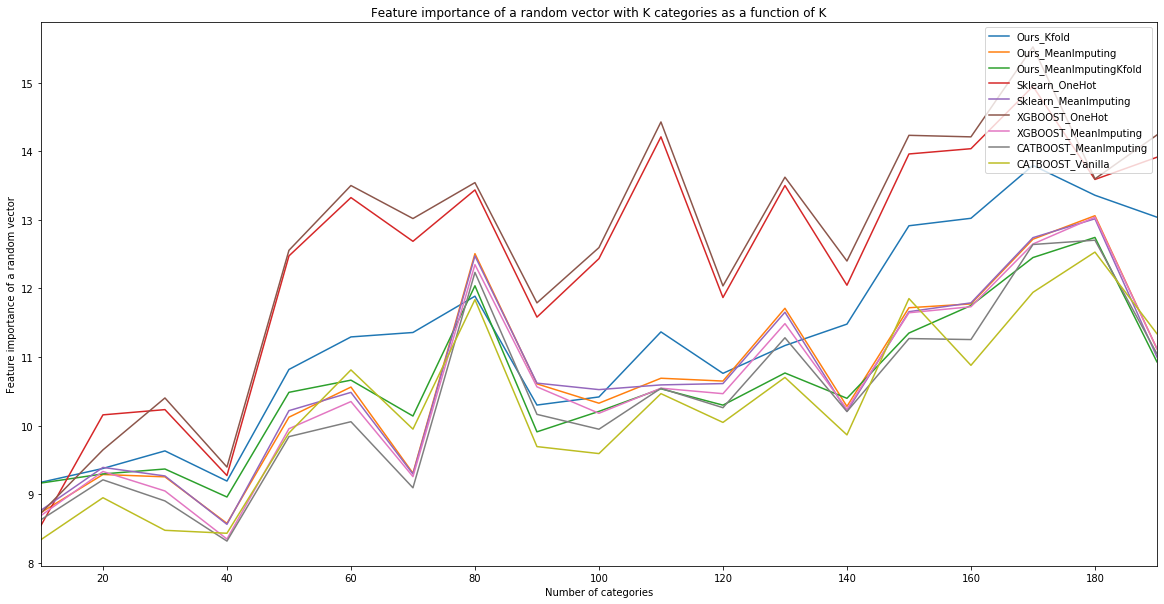

In [27]:
plt.rcParams['figure.figsize'] = [20, 10]
ax = results_df.drop(columns = ['Ours_Vanilla']).plot()
ax.set_xlabel("Number of categories")
ax.set_ylabel("Feature importance of a random vector")
ax.set_title("Feature importance of a random vector with K categories as a function of K")
plt.legend(loc='upper right')
plt.show()

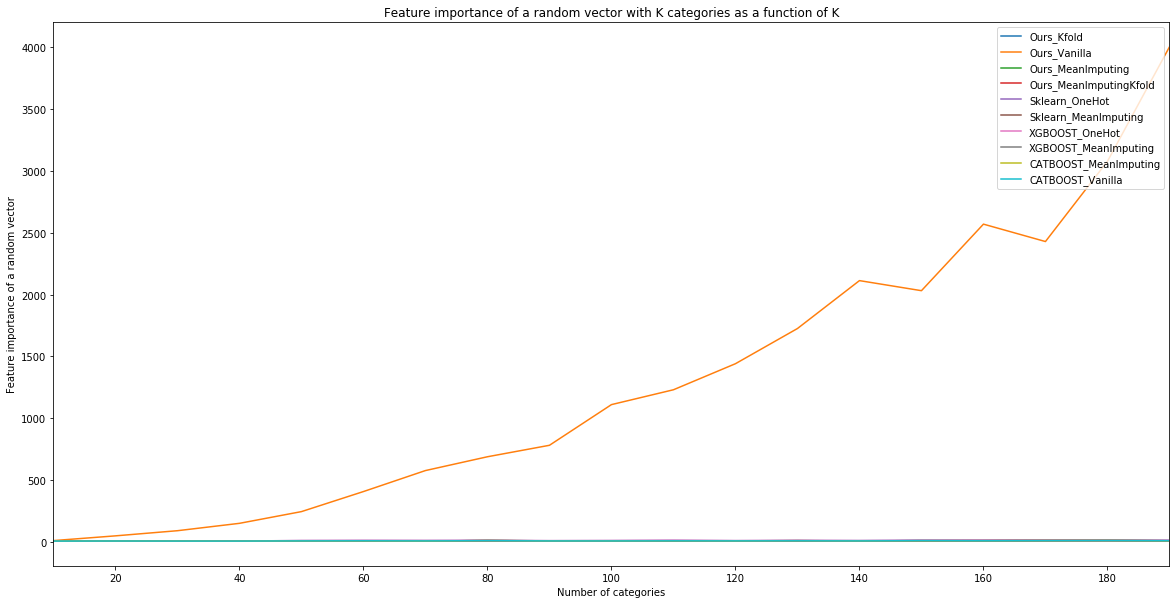

In [28]:
plt.rcParams['figure.figsize'] = [20, 10]
ax = results_df.plot()
ax.set_xlabel("Number of categories")
ax.set_ylabel("Feature importance of a random vector")
ax.set_title("Feature importance of a random vector with K categories as a function of K")
plt.legend(loc='upper right')
plt.show()